In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Some references
https://machinelearningmastery.com/xgboost-python-mini-course/  
https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

# Dataset loading

In [2]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 665)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,bendlength_bend_edge_length_std_04,bendlength_bend_edge_length_min_04,bendlength_bend_edge_length_max_04,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,163.73709,29.010676,594.972659,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0.00000,0.000000,0.000000,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0.00000,0.000000,0.000000,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0.00000,0.000000,0.000000,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0.00000,0.000000,0.000000,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [3]:
#dataset.columns.values

In [4]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')

dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
temp --> 5326
bendlength_deformation_length_00 --> 296
bendlength_deformation_length_01 --> 112
bendlength_deformation_length_02 --> 3
bendlength_deformation_length_03 --> 1
Done !


(5401, 665)

In [5]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('benddxf_')]
subset  = [x for x in dataset.columns.values if x.startswith('bendlength_')]


#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5105, 665)

# cleaning to have at least min occurences

In [6]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        print(occ.COART)
        todrop.append(index)
        print(index, 'will be dropped')

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]

dataset.shape

33
1.5 will be dropped
1
2.5 will be dropped
6
20.0 will be dropped


(5065, 665)

# Target definition

In [7]:
target = 'VAMAT'
assert target in ['VAMAT', 'VALAJOUT', 'VALTOT'], 'The target must be in y dataset'

# Is the target "normal" ?

In [8]:
from scipy.stats import skew
skew(dataset[target]) #Nope !

4.574240913134915

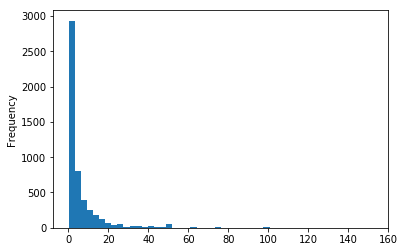

In [9]:
dataset[target].plot.hist(bins=50)
plt.show()

# Outlier tracking - VAMAT

In [10]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [11]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
#dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

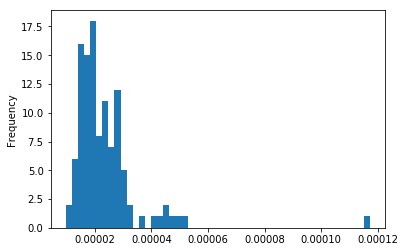

In [12]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [13]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_MPATTERN']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_MPATTERN
thickness                         
2.0       0.02            0.000013
          0.95            0.000045
3.0       0.02            0.000018
          0.95            0.000060
4.0       0.02            0.000023
          0.95            0.000089
5.0       0.02            0.000028
          0.95            0.000091
6.0       0.02            0.000033
          0.95            0.000134
8.0       0.02            0.000044
          0.95            0.000182
10.0      0.02            0.000063
          0.95            0.000248
12.0      0.02            0.000059
          0.95            0.000247
15.0      0.02            0.000085
          0.95            0.000271

In [14]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 666)

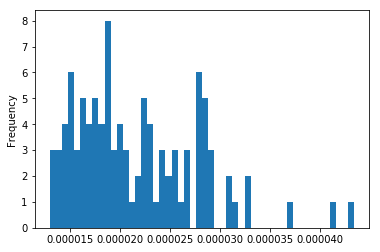

In [15]:
df = dataset[dataset['thickness'] == 2]
df['SURF_COST_MPATTERN'].plot.hist(bins=50)
plt.show()

In [16]:
skew(dataset[target])

4.243692352335607

# Outlier tracking - VALAJOUT

In [17]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [18]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

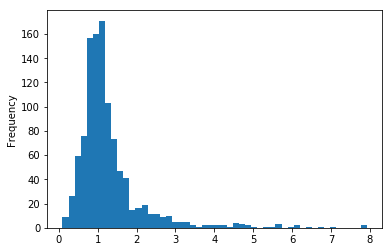

In [19]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

In [20]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.704800
                     0.95          7.743000
          1          0.02          0.515800
                     0.95          2.330000
          2          0.02          0.245067
                     0.95          2.154667
          3          0.02          0.623350
                     0.95          1.954250
          4          0.02          0.573280
                     0.95          2.137800
          5          0.02          0.224867
                     0.95          2.048667
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.700500
                     0.95          1.551500
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.218000
                     0.95          5.710000
          1          0.02          0.393500
                     0.95          1.483750
          2          0.02          0.405467
                     0.95          1.916500
          3          0.02          0.363850
                     0.95          2.401375
...                                     ...
10.0      0          0.02          0.592000
                     0.95          9.260000
          1          0.02          0.968600
                     0.95          4.102000
          2          0.02          0.489067
                     0.95          3.470000
          3          0.02          0.990350
                     0.95          3.877875
          4          0.02          1.137600
                     0.95          3.032000
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.860500
          1          0.02          0.165000
                     0.95          2.267500
          2          0.02          0.716667
                     0.95          1.723333
          3          0.02          0.615000
                     0.95          1.041000
          4          0.02          0.848240
                     0.95          1.819400
15.0      0          0.02          0.737000
                     0.95          8.658000
          1          0.02          1.100000
                     0.95          2.962250
          2          0.02          0.853333
                     0.95          1.526667
          3          0.02          0.870000
                     0.95          1.151250

[148 rows x 1 columns]

In [21]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(4704, 667)

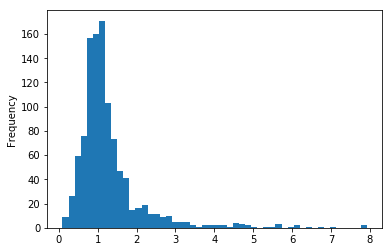

In [22]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

## Target review

In [23]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

,VAMAT
count,4704.000000
mean,5.897545
std,10.382502
min,0.110000
25%,0.810000
50%,2.270000
75%,6.260000
max,125.100000


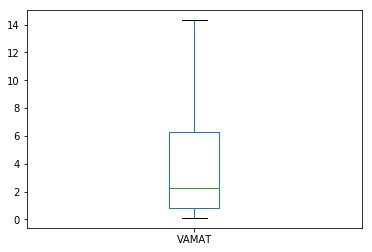

In [24]:
y[[target]].plot.box(sym='')
y[[target]].describe()

# Dataset re-ordering and Splitting

In [25]:
limitedset = ['cut_length', 'num_closed_patterns', 'num_open_patterns', 'total_area', 'minimum_rectangle_area',
              'minimum_rectangle_dim1', 'minimum_rectangle_dim2', 'convex_hull_area', 'no_hole_area',]

# 1 Bend as a float
limitedset.append('thickness')

# 2 Thickness as categories
#limitedset.extend([x for x in dataset.columns.values if x.startswith('thick_')])

# 3 Different counts
limitedset.extend(['radius_count', 'direction_count', 'bend_count'])

# 4 Bends in groups
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bend_gr_')])

# 5 bends according DXF
#limitedset.extend([x for x in dataset.columns.values if x.startswith('benddxf_')])

# 6 according DXF, sorted by length
#limitedset.extend([x for x in dataset.columns.values if x.startswith('bendlength_')])


print(len(limitedset))
limitedset

13


['cut_length',
 'num_closed_patterns',
 'num_open_patterns',
 'total_area',
 'minimum_rectangle_area',
 'minimum_rectangle_dim1',
 'minimum_rectangle_dim2',
 'convex_hull_area',
 'no_hole_area',
 'thickness',
 'radius_count',
 'direction_count',
 'bend_count']

In [26]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])

print(X_train.shape, X_test.shape)

#ONLY FOR DATASET CLEANING PURPOSE
#X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.5, random_state=0 ,stratify=dataset['bend_group'])

(3292, 667) (1412, 667)


# Box_cox feature creation

In [27]:
from scipy import stats
from scipy.special import inv_boxcox
_, lmbda = stats.boxcox(y_train[target], lmbda=None)
y_train['logtarget'] = y_train[target].apply(lambda x: stats.boxcox(x, lmbda))
y_test['logtarget'] = y_test[target].apply(lambda x: stats.boxcox(x, lmbda))

/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/cricket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Blocs creation

In [28]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
# Metric MSE
from sklearn.metrics import mean_squared_error

In [30]:
# Metric MAE
from sklearn.metrics import mean_absolute_error

In [31]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [32]:
#regressions
import xgboost as xgb

xgb1 = xgb.XGBRegressor(random_state=0, n_estimators = 300, n_jobs=-2, eval_metric='rmse')

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Direct prediction

## Step 1

In [34]:
#Pipe definition
pipe1 = [('scaler', scaler), ('xgb', xgb1)]

In [35]:
regpip1 = Pipeline(pipe1)

In [36]:
# STEP1

if target == 'VAMAT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,5,7],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[5,7, 9, 10],
    }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[4,5,6,7],
    }
else:
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[4,5,6,7],
    }

In [37]:

#MSE version
gridxgb1 = GridSearchCV(regpip1, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

#MAPE version
#gridxgb1 = GridSearchCV(regpip1, param_grid, cv=3, n_jobs=-2, scoring=mape_scorer, verbose=1)

gridxgb1.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=5, total=   1.0s
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=5, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=7 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=7 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=5, total=   1.1s
[CV] xgb__max_depth=3, xgb__min_child_weight=7 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=7, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=9 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=7, total=   1.1s
[CV] xgb__max_depth=3, xgb__min_child_weight=9 .......................
[CV] ........ xg

[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:   20.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__max_depth': [3, 5, 7], 'xgb__min_child_weight': [5, 7, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [38]:
print('target        :', target)
print('best score    :', gridxgb1.best_score_)
print('best params   :', gridxgb1.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb1.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb1.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb1.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb1.get_params())

target        : VAMAT
best score    : -5.755352119492585
best params   : {'xgb__max_depth': 3, 'xgb__min_child_weight': 5}
MAPE test set : 15.850308734869644
MSE  test set : 4.121245060988049
MSE train set : 0.777742242579308

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 2

In [39]:
# STEP2

if target == 'VAMAT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
else:
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
cleaneddict = {k[5:]:v for k,v in gridxgb1.best_params_.items()}
mergeddict = {**xgb1.get_params(), **cleaneddict}
xgb2 = xgb.XGBRegressor(**mergeddict)
pipe2 = [('scaler', scaler), ('xgb', xgb2)]
regpip2 = Pipeline(pipe2)
gridxgb2 = GridSearchCV(regpip2, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb2.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] ................................... xgb__gamma=0.0, total=   1.0s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.0s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.2s
[CV] xgb__gamma=0.25 .................................................
[CV] .................................. xgb__gamma=0.25, total=   1.0s
[CV] xgb__gamma=0.5 ..................................................
[CV] .................................. xgb__gamma=0.25, total=   0.9s
[CV] xgb__gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:    5.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [40]:
print('target        :', target)
print('best score    :', gridxgb2.best_score_)
print('best params   :', gridxgb2.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb2.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb2.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb2.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb2.get_params())

target        : VAMAT
best score    : -5.755352119492585
best params   : {'xgb__gamma': 0.0}
MAPE test set : 15.850308734869644
MSE  test set : 4.121245060988049
MSE train set : 0.777742242579308

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 3

In [41]:
# STEP3

if target == 'VAMAT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
else:
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }

cleaneddict = {k[5:]:v for k,v in gridxgb2.best_params_.items()}
mergeddict = {**xgb2.get_params(), **cleaneddict}
xgb3 = xgb.XGBRegressor(**mergeddict)
pipe3 = [('scaler', scaler), ('xgb', xgb3)]
regpip3 = Pipeline(pipe3)
gridxgb3 = GridSearchCV(regpip3, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb3.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   0.9s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   0.7s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   0.8s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__c

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:    9.2s


[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.7, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   0.9s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   0.7s
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   0.8s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .

[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   21.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_dept...reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ]), 'xgb__colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [42]:
print('target        :', target)
print('best score    :', gridxgb3.best_score_)
print('best params   :', gridxgb3.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb3.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb3.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb3.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb3.get_params())

target        : VAMAT
best score    : -5.229664348601237
best params   : {'xgb__colsample_bytree': 1.0, 'xgb__subsample': 0.7}
MAPE test set : 21.495825567901143
MSE  test set : 3.9975136330280456
MSE train set : 0.8446108783343615

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'rmse'}


## Step 4

In [43]:
# STEP4

if target == 'VAMAT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
else:
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }

cleaneddict = {k[5:]:v for k,v in gridxgb3.best_params_.items()}
mergeddict = {**xgb3.get_params(), **cleaneddict}
xgb4 = xgb.XGBRegressor(**mergeddict)
pipe4 = [('scaler', scaler), ('xgb', xgb4)]
regpip4 = Pipeline(pipe4)
gridxgb4 = GridSearchCV(regpip4, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb4.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   0.9s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.0s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.1s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   0.9s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   0.9s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   11.2s


[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   0.8s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.0s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.0s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   0.9s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   0.8s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   0.8s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ........ xgb__reg_alpha=0.1, xgb__reg_lambda=0.001, total=   0.9s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.01 ........................
[CV] .

[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   0.9s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   0.8s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .

[Parallel(n_jobs=-2)]: Done 147 out of 147 | elapsed:   40.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, mis...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__reg_alpha': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0], 'xgb__reg_lambda': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [44]:
print('target        :', target)
print('best score    :', gridxgb4.best_score_)
print('best params   :', gridxgb4.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb4.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb4.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb4.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb4.get_params())

target        : VAMAT
best score    : -5.071771744711454
best params   : {'xgb__reg_alpha': 1, 'xgb__reg_lambda': 0.1}
MAPE test set : 20.3472251425092
MSE  test set : 3.927363215490665
MSE train set : 0.786560546180491

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.7, 'eval_metric': 'rmse'}


## Step 5

In [45]:
# STEP5

if target == 'VAMAT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
else:
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }

cleaneddict = {k[5:]:v for k,v in gridxgb4.best_params_.items()}
mergeddict = {**xgb4.get_params(), **cleaneddict}
xgb5 = xgb.XGBRegressor(**mergeddict)
pipe = [('scaler', scaler), ('xgb', xgb5)]
regpip = Pipeline(pipe)
gridxgb = GridSearchCV(regpip, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_squared_error', verbose=2)

gridxgb.fit(X_train[limitedset], y_train[target])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   0.9s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.0s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.1s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.0s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .......................... xgb__learning_rate=0.05, total=   0.9s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .............

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    3.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, mis..._alpha=1,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__learning_rate': [0.01, 0.05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [46]:
print('target        :', target)
print('best score    :', gridxgb.best_score_)
print('best params   :', gridxgb.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], gridxgb.predict(X_test[limitedset]))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], gridxgb.predict(X_test[limitedset]))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], gridxgb.predict(X_train[limitedset]))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb5.get_params())

target        : VAMAT
best score    : -5.467764892088234
best params   : {'xgb__learning_rate': 0.05}
MAPE test set : 26.538379634162858
MSE  test set : 3.9932012604706615
MSE train set : 1.3920571864176696

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.7, 'eval_metric': 'rmse'}


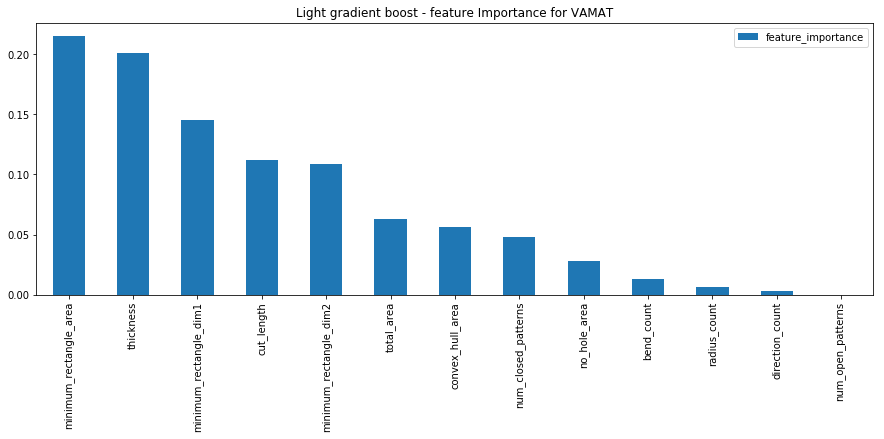

In [47]:
featimp = list(gridxgb.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - feature Importance for {target}')
plt.show()

# BOX-COX prediction

In [48]:
import xgboost as xgb
xgb1 = xgb.XGBRegressor(random_state=0, n_estimators = 400, n_jobs=-2, eval_metric='mae')
pipe1 = [('scaler', scaler), ('xgb', xgb1)]
regpip1log = Pipeline(pipe1)

## Step 1

In [49]:
# STEP1
if target == 'VAMAT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
else:
    param_grid = {
        #'xgb__max_depth':range(3,20,2),
        'xgb__max_depth':[3,4,5],
        #'xgb__min_child_weight':range(3,7,2),
        'xgb__min_child_weight':[1,2,3,4,5],
    }
    
gridxgb1log = GridSearchCV(regpip1log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb1log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] xgb__max_depth=3, xgb__min_child_weight=1 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   0.9s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   0.9s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=1, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=2 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=2, total=   0.9s
[CV] xgb__max_depth=3, xgb__min_child_weight=3 .......................
[CV] ........ xgb__max_depth=3, xgb__min_child_weight=2, total=   1.0s
[CV] xgb__max_depth=3, xgb__min_child_weight=3 .......................
[CV] ........ xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   13.5s


[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   1.4s
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   1.5s
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=3, total=   1.5s
[CV] xgb__max_depth=5, xgb__min_child_weight=4 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   1.4s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   1.4s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=4, total=   1.5s
[CV] xgb__max_depth=5, xgb__min_child_weight=5 .......................
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=5, total=   1.4s
[CV] ........ xgb__max_depth=5, xgb__min_child_weight=5, total=   1.5s
[CV] .

[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:   18.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__max_depth': [3, 4, 5], 'xgb__min_child_weight': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [50]:
print('target        :', target)
print('best score    :', gridxgb1log.best_score_)
print('best params   :', gridxgb1log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb1log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb1log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb1log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb1.get_params())

target        : VAMAT
best score    : -0.09474067540870451
best params   : {'xgb__max_depth': 5, 'xgb__min_child_weight': 2}
MAPE test set : 9.168276749086695
MSE  test set : 3.445668483652633
MSE train set : 0.31075344227345025

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 2

In [51]:
# STEP2
if target == 'VAMAT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }
else:
    param_grid = {
        'xgb__gamma':np.linspace(0,1,5)
    }

    
cleaneddict = {k[5:]:v for k,v in gridxgb1log.best_params_.items()}
mergeddict = {**xgb1.get_params(), **cleaneddict}
xgb2 = xgb.XGBRegressor(**mergeddict)
pipe2 = [('scaler', scaler), ('xgb', xgb2)]
regpip2log = Pipeline(pipe2)
gridxgb2log = GridSearchCV(regpip2log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb2log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] xgb__gamma=0.0 ..................................................
[CV] ................................... xgb__gamma=0.0, total=   1.4s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.5s
[CV] xgb__gamma=0.25 .................................................
[CV] ................................... xgb__gamma=0.0, total=   1.6s
[CV] xgb__gamma=0.25 .................................................
[CV] .................................. xgb__gamma=0.25, total=   1.4s
[CV] xgb__gamma=0.5 ..................................................
[CV] .................................. xgb__gamma=0.25, total=   1.5s
[CV] xgb__gamma=0.5 ..................................................
[CV] ............

[Parallel(n_jobs=-2)]: Done  15 out of  15 | elapsed:    7.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [52]:
print('target        :', target)
print('best score    :', gridxgb2log.best_score_)
print('best params   :', gridxgb2log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb2log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb2log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb2log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb2.get_params())

target        : VAMAT
best score    : -0.09474067540870451
best params   : {'xgb__gamma': 0.0}
MAPE test set : 9.168276749086695
MSE  test set : 3.445668483652633
MSE train set : 0.31075344227345025

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 3

In [53]:
# STEP3
if target == 'VAMAT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }
else:
    param_grid = {
        'xgb__subsample':np.linspace(0.6,1,5),
        'xgb__colsample_bytree':np.linspace(0.6,1,5),
    }

    
cleaneddict = {k[5:]:v for k,v in gridxgb2log.best_params_.items()}
mergeddict = {**xgb2.get_params(), **cleaneddict}
xgb3 = xgb.XGBRegressor(**mergeddict)
pipe3 = [('scaler', scaler), ('xgb', xgb3)]
regpip3log = Pipeline(pipe3)
gridxgb3log = GridSearchCV(regpip3log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb3log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.6 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.1s
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.6, total=   1.2s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.7 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   1.0s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.6, xgb__subsample=0.7, total=   1.1s
[CV] xgb__colsample_bytree=0.6, xgb__subsample=0.8 ...................
[CV] .... xgb__c

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   15.1s


[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.8 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.8, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=0.9 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.4s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=0.9, total=   1.3s
[CV] xgb__colsample_bytree=0.8, xgb__subsample=1.0 ...................
[CV] .... xgb__colsample_bytree=0.8, xgb__subsample=1.0, total=   1.4s
[CV] x

[Parallel(n_jobs=-2)]: Done  75 out of  75 | elapsed:   34.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0.0, learning_rate=0.1,
       max_delta_step=0, max_depth...ate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__subsample': array([0.6, 0.7, 0.8, 0.9, 1. ]), 'xgb__colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [54]:
print('target        :', target)
print('best score    :', gridxgb3log.best_score_)
print('best params   :', gridxgb3log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb3log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb3log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb3log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb3.get_params())

target        : VAMAT
best score    : -0.09474067540870451
best params   : {'xgb__colsample_bytree': 1.0, 'xgb__subsample': 1.0}
MAPE test set : 9.168276749086695
MSE  test set : 3.445668483652633
MSE train set : 0.31075344227345025

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'eval_metric': 'mae'}


## Step 4

In [55]:
# STEP4
if target == 'VAMAT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
elif target == 'VALAJOUT':
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }
else:
    param_grid = {
        #'xgb__reg_alpha':np.logspace(-3,3,5),
        'xgb__reg_alpha':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
        #'xgb__reg_lambda':np.logspace(-3,3,5),
        'xgb__reg_lambda':[1e-3, 1e-2, 1e-1, 0, 1,1e2, 1e3],
                }

    
cleaneddict = {k[5:]:v for k,v in gridxgb3log.best_params_.items()}
mergeddict = {**xgb3.get_params(), **cleaneddict}
xgb4 = xgb.XGBRegressor(**mergeddict)
pipe4 = [('scaler', scaler), ('xgb', xgb4)]
regpip4log = Pipeline(pipe4)
gridxgb4log = GridSearchCV(regpip4log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgb4log.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.001 .....................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.5s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.6s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ...... xgb__reg_alpha=0.001, xgb__reg_lambda=0.001, total=   1.8s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.01 ......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.6s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xgb__reg_alpha=0.001, xgb__reg_lambda=0.01, total=   1.7s
[CV] xgb__reg_alpha=0.001, xgb__reg_lambda=0.1 .......................
[CV] ....... xg

[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   19.7s


[CV] ........... xgb__reg_alpha=0.01, xgb__reg_lambda=1, total=   1.5s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=100.0 ......................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.5s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.6s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ....... xgb__reg_alpha=0.01, xgb__reg_lambda=100.0, total=   1.6s
[CV] xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0 .....................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.5s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.6s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] ...... xgb__reg_alpha=0.01, xgb__reg_lambda=1000.0, total=   1.5s
[CV] xgb__reg_alpha=0.1, xgb__reg_lambda=0.001 .......................
[CV] .

[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.5s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.5s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=0, total=   1.6s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1 .............................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.4s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.5s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .............. xgb__reg_alpha=1, xgb__reg_lambda=1, total=   1.4s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=100.0 .........................
[CV] .......... xgb__reg_alpha=1, xgb__reg_lambda=100.0, total=   1.6s
[CV] xgb__reg_alpha=1, xgb__reg_lambda=1000.0 ........................
[CV] .

[Parallel(n_jobs=-2)]: Done 147 out of 147 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='mae', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, miss...eg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__reg_alpha': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0], 'xgb__reg_lambda': [0.001, 0.01, 0.1, 0, 1, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [56]:
print('target        :', target)
print('best score    :', gridxgb4log.best_score_)
print('best params   :', gridxgb4log.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgb4log.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgb4log.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgb4log.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb4.get_params())

target        : VAMAT
best score    : -0.0946239823655066
best params   : {'xgb__reg_alpha': 0.001, 'xgb__reg_lambda': 1}
MAPE test set : 9.198319577708922
MSE  test set : 3.767704984325319
MSE train set : 0.365460193727414

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1.0, 'eval_metric': 'mae'}


## Step 5

In [57]:
# STEP5

if target == 'VAMAT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
elif target == 'VALAJOUT':
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }
else:
    param_grid = {
        'xgb__learning_rate':[.01, .05, .001],
                }

    
cleaneddict = {k[5:]:v for k,v in gridxgb4log.best_params_.items()}
mergeddict = {**xgb4.get_params(), **cleaneddict}
xgb5 = xgb.XGBRegressor(**mergeddict)
pipe5 = [('scaler', scaler), ('xgb', xgb5)]
regpip5log = Pipeline(pipe5)
gridxgblog = GridSearchCV(regpip5log, param_grid, cv=3, n_jobs=-2, scoring='neg_mean_absolute_error', verbose=2)
gridxgblog.fit(X_train[limitedset], y_train['logtarget'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] xgb__learning_rate=0.01 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.5s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.6s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.01, total=   1.7s
[CV] xgb__learning_rate=0.05 .........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.7s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .......................... xgb__learning_rate=0.05, total=   1.6s
[CV] xgb__learning_rate=0.001 ........................................
[CV] .............

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:    4.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='mae', gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, miss...  reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0))]),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'xgb__learning_rate': [0.01, 0.05, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [58]:
print('target        :', target)
print('best score    :', gridxgblog.best_score_)
print('best params   :', gridxgblog.best_params_)
mapetest=mean_absolute_percentage_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))
print('MAPE test set :', mapetest)
msetest = mean_squared_error(y_test[target], inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda))
print('MSE  test set :', msetest)
msetrain = mean_squared_error(y_train[target], inv_boxcox(gridxgblog.predict(X_train[limitedset]), lmbda))
print('MSE train set :', msetrain)
print()
print('initial params :', xgb5.get_params())

target        : VAMAT
best score    : -0.09589057189102033
best params   : {'xgb__learning_rate': 0.05}
MAPE test set : 9.108185677325478
MSE  test set : 3.9820864472115165
MSE train set : 0.727766296217706

initial params : {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1.0, 'gamma': 0.0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 2, 'missing': None, 'n_estimators': 300, 'n_jobs': -2, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0.001, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1.0, 'eval_metric': 'mae'}


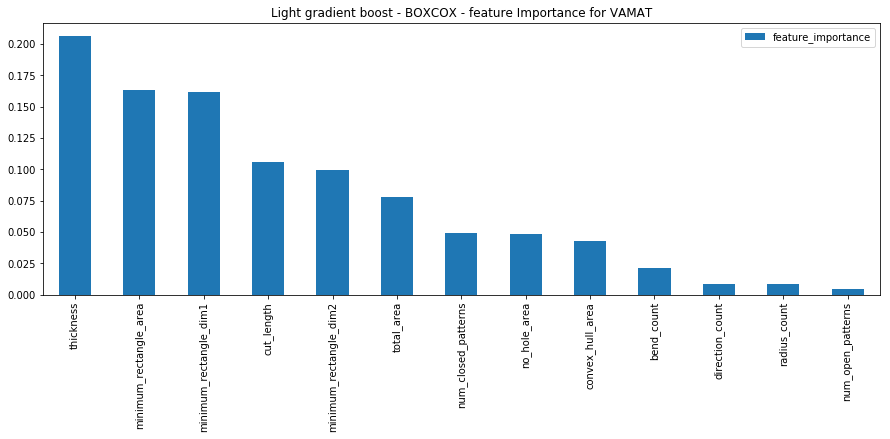

In [59]:
featimp = list(gridxgblog.best_estimator_.named_steps['xgb'].feature_importances_)
df = pd.DataFrame({'feature_importance':featimp}, index =limitedset)
df = df.sort_values('feature_importance', ascending=False)
df[:50].plot.bar(figsize=(15,5))
plt.title(f'Light gradient boost - BOXCOX - feature Importance for {target}')
plt.show()

# Solution comparison

In [60]:
prediction_xgb = gridxgb.predict(X_test[limitedset])
prediction_xgb_log = inv_boxcox(gridxgblog.predict(X_test[limitedset]), lmbda)

In [61]:
resultset = pd.DataFrame({f'target': y_test[target],
                          'prediction_xgb':prediction_xgb,
                          'prediction_xgb_log':prediction_xgb_log,
                            }, index=y_test.index)
resultset.head()

,prediction_xgb,prediction_xgb_log,target
COART,,,
L3041770,3.283121,3.485623,3.40
L6802530,0.200985,0.177102,0.15
L2605410,11.105876,10.595864,11.21
L7058820,7.294131,7.521125,6.70
L6011841,21.385977,21.534868,21.00


In [62]:
#Solution saving
resultset.to_csv(f'{target}_pred_xgb.csv')


In [63]:
#MAPE
mape = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb'])
mapelog = mean_absolute_percentage_error(resultset['target'], resultset['prediction_xgb_log'])
print('mape', mape)
print('mapelog', mapelog)

mape 26.538379634162858
mapelog 9.108185677325478


In [64]:
#MSE
mse = mean_squared_error(resultset['target'], resultset['prediction_xgb'])
mselog = mean_squared_error(resultset['target'], resultset['prediction_xgb_log'])
print('mse', mse)
print('mselog', mselog)

mse 3.9932012604706615
mselog 3.9820864472115165


In [65]:
resultset['MSE_xgb'] = (resultset['target']-resultset['prediction_xgb'])**2
resultset['MSE_log_xgb'] = (resultset['target']-resultset['prediction_xgb_log'])**2
resultset.head()

,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_log_xgb
COART,,,,,
L3041770,3.283121,3.485623,3.40,0.013661,0.007331
L6802530,0.200985,0.177102,0.15,0.002599,0.000735
L2605410,11.105876,10.595864,11.21,0.010842,0.377163
L7058820,7.294131,7.521125,6.70,0.352991,0.674246
L6011841,21.385977,21.534868,21.00,0.148978,0.286084


In [66]:
resultset['MSE_xgb'].mean()

3.99320126047066

In [67]:
#Data assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,prediction_xgb,prediction_xgb_log,target,MSE_xgb,MSE_log_xgb,cut_length,num_closed_patterns,num_open_patterns,total_area,...,bendlength_bend_edge_length_max_04,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_MPATTERN,APPROX_BEND_COST
0,L3041770,3.283121,3.485623,3.40,0.013661,0.007331,1836.297974,1,0,41957.070312,...,276.714,3.40,6.38,9.78,0.000009,0.000008,0.000010,3-5,0.000081,1.063333
1,L6802530,0.200985,0.177102,0.15,0.002599,0.000735,374.891052,4,0,2171.109131,...,0.000,0.15,3.37,3.52,0.000009,0.000007,0.000010,1-2,0.000060,1.123333
2,L2605410,11.105876,10.595864,11.21,0.010842,0.377163,3051.648682,16,0,140381.875000,...,0.000,11.21,5.43,16.64,0.000009,0.000008,0.000010,1-2,0.000079,2.715000
3,L7058820,7.294131,7.521125,6.70,0.352991,0.674246,1793.807251,3,0,65955.062500,...,0.000,6.70,2.12,8.82,0.000007,0.000006,0.000007,0,0.000086,2.120000
4,L6011841,21.385977,21.534868,21.00,0.148978,0.286084,2885.971436,9,0,263535.531250,...,0.000,21.00,5.38,26.38,0.000012,0.000008,0.000013,1-2,0.000079,1.793333


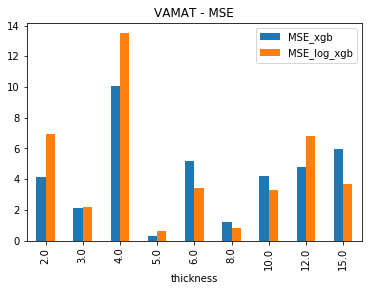

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
thickness,,,
2.0,4.136081,6.943667,37
3.0,2.111274,2.161316,132
4.0,10.068444,13.494991,168
5.0,0.325002,0.606236,163
6.0,5.188472,3.401338,316
8.0,1.212669,0.807751,275
10.0,4.197323,3.294934,178
12.0,4.798161,6.837820,96


In [68]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('thickness').agg({'MSE_xgb':['mean'],
                                        'MSE_log_xgb':['mean'],
                                         'COART':['count']})

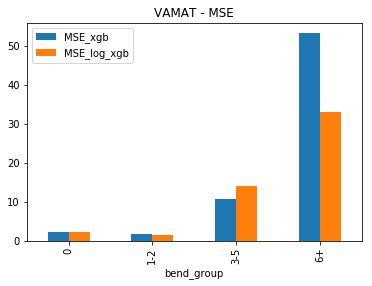

,MSE_xgb,MSE_log_xgb,COART
,mean,mean,count
bend_group,,,
0,2.247145,2.244051,578
1-2,1.662366,1.505662,625
3-5,10.704135,13.921437,184
6+,53.240434,32.922458,25


In [69]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_xgb', 'MSE_log_xgb', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.title(f'{target} - MSE')
plt.show()
comparisonset.groupby('bend_group').agg({'MSE_xgb':['mean'],
                                         'MSE_log_xgb':['mean'],
                                         'COART':['count']})

In [70]:
comparisonset['MAPE_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb']), axis=1)
comparisonset['MAPE_log_error'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['prediction_xgb_log']), axis=1)

comparisonset[['target', 'prediction_xgb', 'MAPE_error', 'prediction_xgb_log', 'MAPE_log_error']].head()

,target,prediction_xgb,MAPE_error,prediction_xgb_log,MAPE_log_error
0,3.40,3.283121,3.437628,3.485623,2.518320
1,0.15,0.200985,33.989871,0.177102,18.068069
2,11.21,11.105876,0.928850,10.595864,5.478463
3,6.70,7.294131,8.867624,7.521125,12.255595
4,21.00,21.385977,1.837985,21.534868,2.546992


In [71]:
#MAPE
print('MAPE', comparisonset['MAPE_error'].mean())
print('MAPE log', comparisonset['MAPE_log_error'].mean())

MAPE 26.5383796341628
MAPE log 9.108185677325471


In [72]:
#If bends use this line
if target == 'VALAJOUT' or target == 'VALTOT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])

#If no bends use this line
if target == 'VAMAT':
    df = comparisonset[['MSE_xgb', 'MSE_log_xgb','MAPE_error', 'MAPE_log_error', 'thickness', 'COART']].groupby(['thickness'])

df.agg({'MSE_xgb': ['mean', 'max'],
        'MSE_log_xgb': ['mean', 'max'],
        'MAPE_error': ['mean', 'max'],
        'MAPE_log_error': ['mean', 'max'],
        'COART':['count'] })

MSE_xgb              MSE_log_xgb              MAPE_error  \
                mean          max        mean          max       mean   
thickness                                                               
2.0         4.136081    49.792886    6.943667    72.651046  38.467443   
3.0         2.111274    71.235163    2.161316   155.563222  41.344363   
4.0        10.068444  1157.105700   13.494991  1751.344632  28.351190   
5.0         0.325002    21.111533    0.606236    74.585043  18.932021   
6.0         5.188472  1235.253269    3.401338   606.009977  13.307040   
8.0         1.212669    55.669092    0.807751    49.741051  22.304081   
10.0        4.197323   136.326946    3.294934   145.093611  17.838485   
12.0        4.798161   173.454816    6.837820   336.511688  74.588146   
15.0        5.987554    90.618107    3.715712    55.187793  44.003451   

                      MAPE_log_error             COART  
                  max           mean         max count  
thickness                                               
2.0        513.219062      13.186509   47.724290    37  
3.0        334.993617       8.079246   42.943175   132  
4.0        216.994435       8.819197   56.262696   168  
5.0        110.814716       7.091654   42.861553   163  
6.0         79.713408       8.148453   53.111693   316  
8.0        254.239027       8.311566  127.392693   275  
10.0       251.042795       8.935492  109.352136   178  
12.0       658.934231      15.459802   84.585284    96  
15.0       454.512162      15.608121   53.152227    47

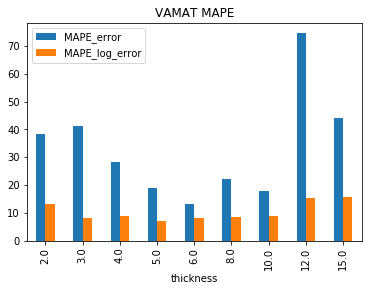

,MAPE_error,MAPE_log_error,COART
,mean,mean,count
thickness,,,
2.0,38.467443,13.186509,37
3.0,41.344363,8.079246,132
4.0,28.351190,8.819197,168
5.0,18.932021,7.091654,163
6.0,13.307040,8.148453,316
8.0,22.304081,8.311566,275
10.0,17.838485,8.935492,178
12.0,74.588146,15.459802,96


In [73]:
df = comparisonset[['MAPE_error', 'MAPE_log_error', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
comparisonset.groupby('thickness').agg({'MAPE_error':['mean'],
                                         'MAPE_log_error':['mean'],
                                         'COART':['count']})

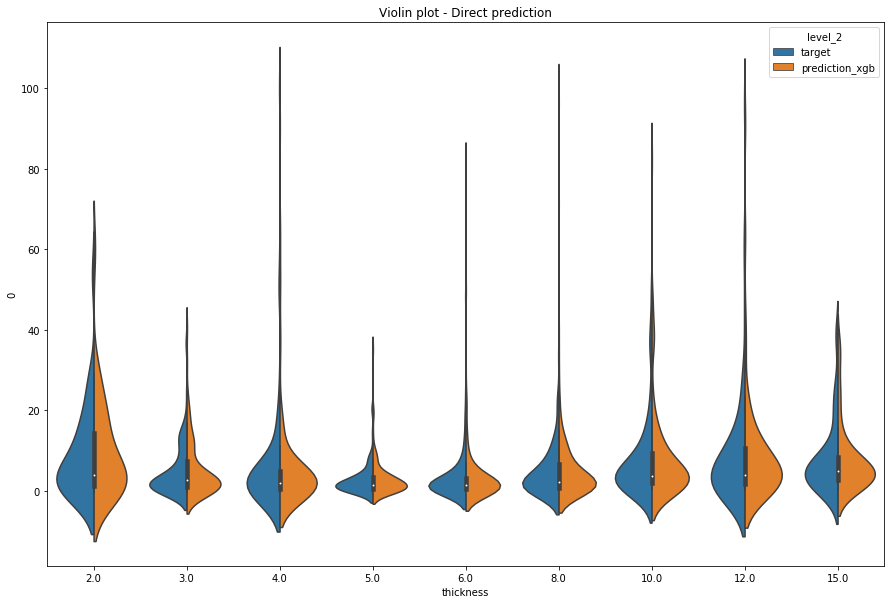

In [74]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - Direct prediction')
plt.show()

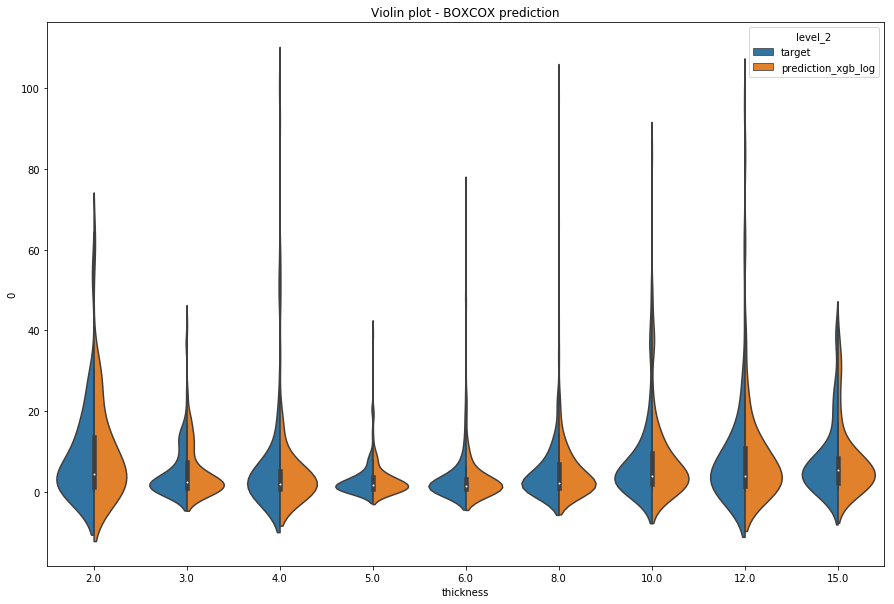

In [75]:
#Violin plot
df=comparisonset[['target', 'prediction_xgb_log', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-100, 100)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)
plt.title('Violin plot - BOXCOX prediction')
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


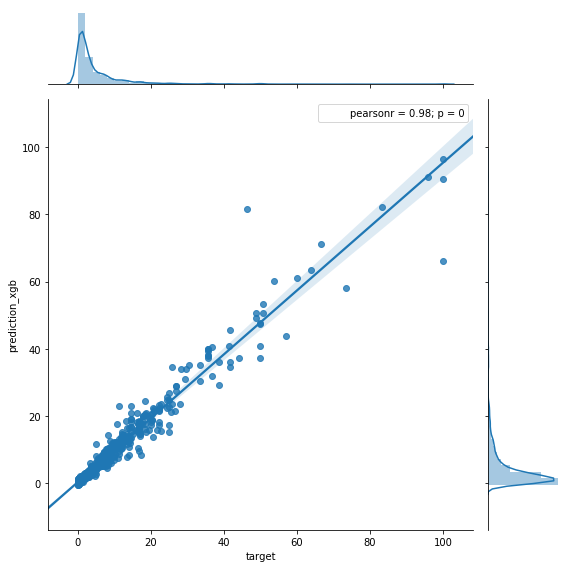

In [76]:
# No BOXCOX
sns.jointplot(x='target', y='prediction_xgb', data=comparisonset, kind='reg', size=8)
plt.show()

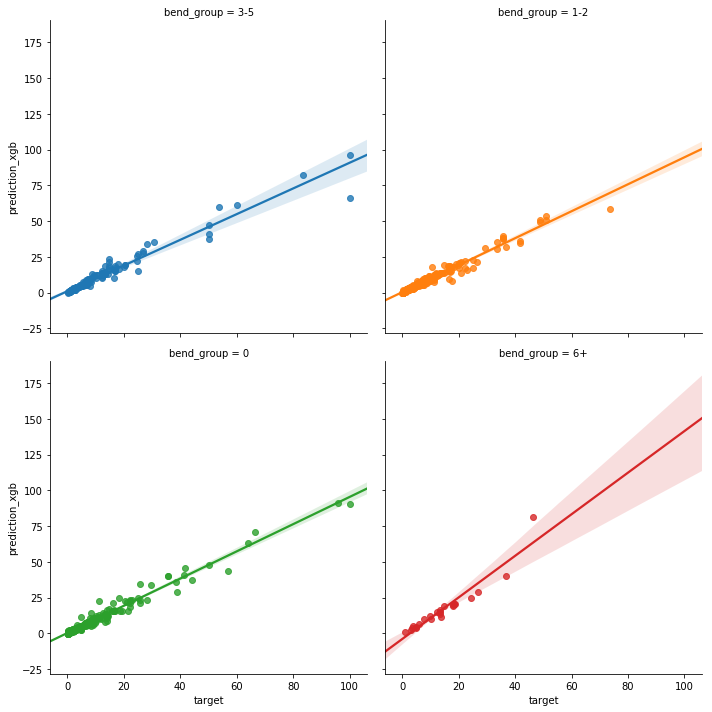

In [77]:
sns.lmplot(x='target',
           y='prediction_xgb',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           legend=True)
plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


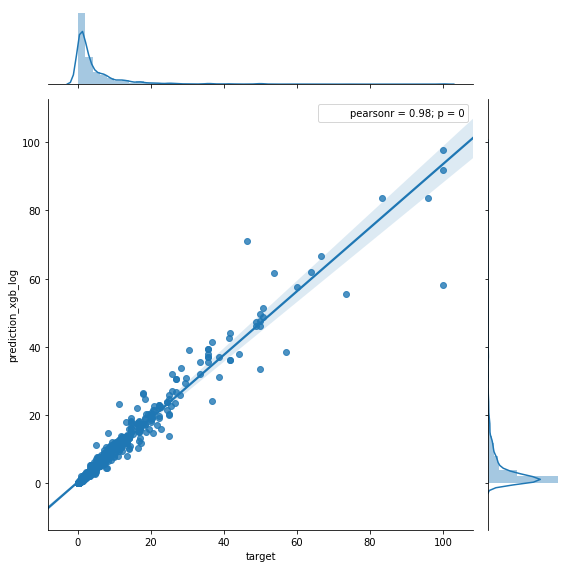

In [78]:
# With BOXCOX
sns.jointplot(x='target', y='prediction_xgb_log', data=comparisonset, kind='reg',size=8)
plt.show()

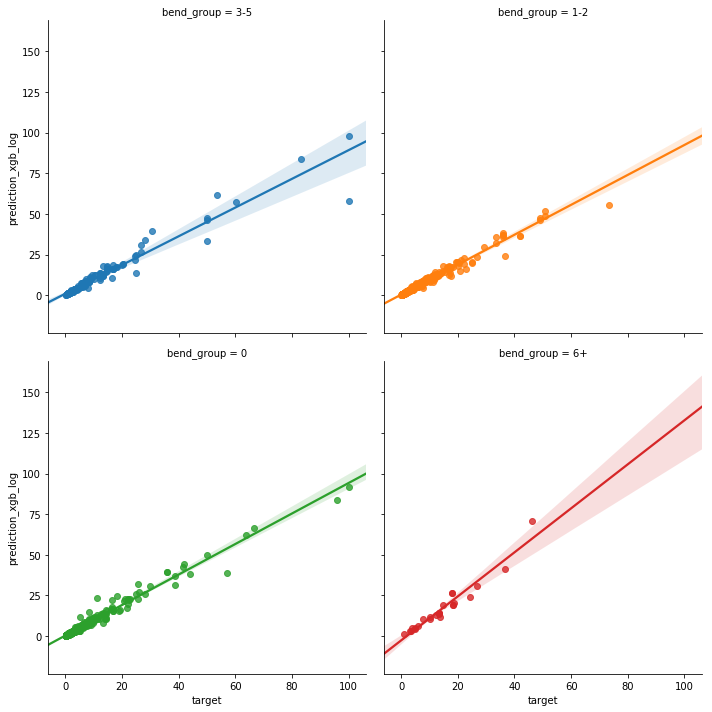

In [79]:
sns.lmplot(x='target',
           y='prediction_xgb_log',
           col='bend_group',
           hue='bend_group',
           data=comparisonset,
           aspect=1,
           col_wrap=2,
           size=5,
           #palette="Set1",
           legend=True),
plt.show()

In [80]:
df = comparisonset[['MSE_xgb', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_xgb'].nlargest(5)

worst.to_csv('../Y3 - Sample data/Z3 - outliers.csv')
print(worst.shape)
worst

(45,)


thickness  COART   
2.0        L6006290      49.792886
           L2503310      41.910383
           L5606461      10.288193
           L6003250       6.558015
           L7064170       4.962769
3.0        L5701480      71.235163
           L6015930      40.133501
           L8037510      24.044390
           L7069760      19.991216
           L3103511      19.928652
4.0        L1608630    1157.105700
           L8055410     162.073844
           L3119040      92.577155
           L6707490      84.258102
           L8411820      37.680633
5.0        L8834370      21.111533
           L3101780       3.915052
           L8053060       2.828559
           L7013791       2.094433
           L7013792       2.094433
6.0        L7065230    1235.253269
           L8045330     231.666478
           L6005820      39.017126
           L6000550      22.614273
           L6005982       9.681001
8.0        L7080610      55.669092
           L8049000      45.228965
           L3125690      29.924796


In [81]:
#comparison

#Thickness filter
df = comparisonset[comparisonset['thickness'] == 4]

#Cost filter Max
#df = df[df[target]<15]

#Cost filter Min
#df = df[df[target]>10] #bend_count

#Min rectangle area
#df = df[df['minimum_rectangle_area'] < 700000]
df = df[df['minimum_rectangle_area'] > 1e+06]

#bend_count filter
df = df[df['bend_count'] == 4]

#df[df['COART']=='L3128890'].T
df.T

,306,1138
COART,L8835250,L1608630
prediction_xgb,33.9649,66.0637
prediction_xgb_log,33.7355,58.2309
target,28.26,100.08
MSE_xgb,32.5463,1157.11
MSE_log_xgb,29.9809,1751.34
cut_length,5476.05,7774
num_closed_patterns,2,1
num_open_patterns,0,0
total_area,913930,2.72349e+06


In [82]:
dataset.loc[['L1608630']].T
#comparisonset[comparisonset['COART'] == 'L3131690']

COART,L1608630
cut_length,7774
num_closed_patterns,1
num_open_patterns,0
total_area,2.72349e+06
minimum_rectangle_area,2.72349e+06
minimum_rectangle_dim1,2970
minimum_rectangle_dim2,917
convex_hull_area,2.72349e+06
no_hole_area,2.72349e+06
thickness,4


# Hyper Opt

In [83]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

https://github.com/hyperopt/hyperopt/wiki/FMin

## Direct prediction

In [171]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight':params['min_child_weight'],
        'gamma':params['gamma'],
        'subsample':params['subsample'],
        'colsample_bytree':params['colsample_bytree'],
        'reg_alpha':params['reg_alpha'],
        'reg_lambda':params['reg_lambda'],
        'learning_rate':params['learning_rate'],
        }
    
    clf = xgb.XGBRegressor(n_jobs=-2,
                           **params,
                            )
    
    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)
    
    score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3).mean()
    #score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_squared_error', cv=3).mean()
    print("MSE {:.3f} params {}".format(score, params))
    return -score

space = {
    'n_estimators': hp.uniform('n_estimators', 100, 500),
    'max_depth': hp.uniform('max_depth', 3, 8),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'gamma':hp.uniform('gamma', 0, 1e2),
    'subsample':hp.uniform('subsample', .5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -1, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -1, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

MSE -7.046 params {'n_estimators': 156, 'max_depth': 5, 'min_child_weight': 5.226963712297064, 'gamma': 54.500021083393726, 'subsample': 0.5809660626910715, 'colsample_bytree': 0.7880584326288249, 'reg_alpha': 0.537279959859719, 'reg_lambda': 0.5982909390038651, 'learning_rate': 0.18021008520837728}
MSE -6.656 params {'n_estimators': 353, 'max_depth': 5, 'min_child_weight': 9.095816694742503, 'gamma': 9.060421601144208, 'subsample': 0.844354222028574, 'colsample_bytree': 0.8759753791695737, 'reg_alpha': 1.2528523802430027, 'reg_lambda': 1.629235038170777, 'learning_rate': 0.15117608039686187}
MSE -8.039 params {'n_estimators': 176, 'max_depth': 7, 'min_child_weight': 4.982413680921711, 'gamma': 38.689888649935114, 'subsample': 0.5364305918472778, 'colsample_bytree': 0.7670360495256741, 'reg_alpha': 0.40980045174981516, 'reg_lambda': 0.5084245475387941, 'learning_rate': 0.1575512892030202}
MSE -6.316 params {'n_estimators': 239, 'max_depth': 3, 'min_child_weight': 4.4336231424726265, 'g

MSE -7.189 params {'n_estimators': 106, 'max_depth': 4, 'min_child_weight': 7.59734697558649, 'gamma': 37.18057532197631, 'subsample': 0.5389249675642434, 'colsample_bytree': 0.9101974787738694, 'reg_alpha': 1.7441569144877103, 'reg_lambda': 0.6412258222374172, 'learning_rate': 0.16946202113315206}
MSE -6.619 params {'n_estimators': 127, 'max_depth': 5, 'min_child_weight': 5.882226007702881, 'gamma': 26.202136280848734, 'subsample': 0.6245227583060738, 'colsample_bytree': 0.84409938533653, 'reg_alpha': 1.3034114063851825, 'reg_lambda': 1.096126432954257, 'learning_rate': 0.1942817682793724}
MSE -6.101 params {'n_estimators': 187, 'max_depth': 6, 'min_child_weight': 3.106708895355427, 'gamma': 13.967603554737739, 'subsample': 0.768023767460776, 'colsample_bytree': 0.9443895769419931, 'reg_alpha': 2.0557390975785386, 'reg_lambda': 1.7749780846660947, 'learning_rate': 0.12387848974145803}
MSE -6.224 params {'n_estimators': 211, 'max_depth': 4, 'min_child_weight': 6.306770865880326, 'gamma

MSE -6.281 params {'n_estimators': 338, 'max_depth': 5, 'min_child_weight': 1.467842587258188, 'gamma': 6.961017020173415, 'subsample': 0.678900520677068, 'colsample_bytree': 0.7501066238935514, 'reg_alpha': 0.8123066263517608, 'reg_lambda': 0.5300705769503148, 'learning_rate': 0.020801918426610742}
MSE -6.480 params {'n_estimators': 244, 'max_depth': 3, 'min_child_weight': 5.0654291824464295, 'gamma': 24.46365142182131, 'subsample': 0.7967323569758663, 'colsample_bytree': 0.6065811736555673, 'reg_alpha': 1.4192322549946734, 'reg_lambda': 0.8387707523153174, 'learning_rate': 0.15314711053269464}
MSE -6.174 params {'n_estimators': 404, 'max_depth': 6, 'min_child_weight': 3.418327371823726, 'gamma': 48.81050110946013, 'subsample': 0.7323542961354899, 'colsample_bytree': 0.8892903146360978, 'reg_alpha': 1.568800751489882, 'reg_lambda': 0.5865344525354241, 'learning_rate': 0.11966708157213243}
MSE -6.526 params {'n_estimators': 377, 'max_depth': 3, 'min_child_weight': 4.214406917534123, 'g

MSE -6.094 params {'n_estimators': 450, 'max_depth': 4, 'min_child_weight': 7.396929705160563, 'gamma': 0.06438293693965846, 'subsample': 0.8621884062375098, 'colsample_bytree': 0.8367309551689575, 'reg_alpha': 1.9261951850690102, 'reg_lambda': 1.9663549304682562, 'learning_rate': 0.0832486014001994}
MSE -5.974 params {'n_estimators': 499, 'max_depth': 4, 'min_child_weight': 6.764311871122665, 'gamma': 26.970653341849165, 'subsample': 0.5863381115737601, 'colsample_bytree': 0.9148124383341083, 'reg_alpha': 0.6802570644120772, 'reg_lambda': 1.7027944597960665, 'learning_rate': 0.12730616365379152}
MSE -6.458 params {'n_estimators': 418, 'max_depth': 5, 'min_child_weight': 5.91953740411236, 'gamma': 21.09453729392767, 'subsample': 0.509412120244783, 'colsample_bytree': 0.762979934069965, 'reg_alpha': 0.498980884246538, 'reg_lambda': 2.6844008681740066, 'learning_rate': 0.10458976576137592}
MSE -6.177 params {'n_estimators': 431, 'max_depth': 3, 'min_child_weight': 6.358911905746336, 'gam

In [172]:
params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'min_child_weight':best['min_child_weight'],
        'gamma':best['gamma'],
        'subsample':best['subsample'],
        'colsample_bytree':best['colsample_bytree'],
        'reg_alpha':best['reg_alpha'],
        'reg_lambda':best['reg_lambda'],
        'learning_rate':best['learning_rate'],
        }

clf = xgb.XGBRegressor(n_jobs=-2, **params,)
pipe = [('scaler', scaler), ('xgb', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train[target])
msetest = mean_squared_error(y_test[target], regpip.predict(X_test[limitedset]))
mapetest = mean_absolute_percentage_error(y_test[target], regpip.predict(X_test[limitedset]))
msetrain = mean_squared_error(y_train[target], regpip.predict(X_train[limitedset]))
#print(clf.get_params())
print(params)
print('MSE  test:', msetest)
print('MSE train:', msetrain)
print('MAPE test:', mapetest)


{'n_estimators': 393, 'max_depth': 3, 'min_child_weight': 1.191064423898848, 'gamma': 9.131560212696836, 'subsample': 0.6011493681332689, 'colsample_bytree': 0.9425809595045176, 'reg_alpha': 2.2815122656326072, 'reg_lambda': 0.4920818401856412, 'learning_rate': 0.03065490716551424}
MSE  test: 4.566026099920549
MSE train: 1.4830627937181253
MAPE test: 26.761142586430033


## BOX-COX

In [173]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_child_weight':params['min_child_weight'],
        #'gamma':params['gamma'],
        'subsample':params['subsample'],
        'colsample_bytree':params['colsample_bytree'],
        'reg_alpha':params['reg_alpha'],
        'reg_lambda':params['reg_lambda'],
        'learning_rate':params['learning_rate'],
        }
    
    clf = xgb.XGBRegressor(n_jobs=-2,
                           **params,
                            )
    
    pipe = [('scaler', scaler), ('xgb', clf)]
    regpip = Pipeline(pipe)
    
    #score = cross_val_score(regpip, X_train[limitedset], y_train[target], scoring='neg_mean_squared_error', cv=3).mean()  neg_mean_absolute_error
    score = cross_val_score(regpip, X_train[limitedset], y_train['logtarget'], scoring='neg_mean_absolute_error', cv=3).mean()
    print("MAE {:.3f} params {}".format(score, params))
    return -score

space = {
    'n_estimators': hp.uniform('n_estimators', 200, 700),
    'max_depth': hp.uniform('max_depth', 3, 10),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'gamma':hp.uniform('gamma', 0, 1e2),
    'subsample':hp.uniform('subsample', .5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -1, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -1, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, .2),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

MAE -0.100 params {'n_estimators': 315, 'max_depth': 8, 'min_child_weight': 4.2628562085937025, 'subsample': 0.9115945138100179, 'colsample_bytree': 0.9392944399508458, 'reg_alpha': 0.9935395766301757, 'reg_lambda': 0.9336665363069108, 'learning_rate': 0.09351357723871781}
MAE -0.103 params {'n_estimators': 228, 'max_depth': 5, 'min_child_weight': 1.326572753214792, 'subsample': 0.5914991068629238, 'colsample_bytree': 0.8595334270263846, 'reg_alpha': 1.0670263737661583, 'reg_lambda': 1.584031051104973, 'learning_rate': 0.09996487051810159}
MAE -0.099 params {'n_estimators': 389, 'max_depth': 5, 'min_child_weight': 6.39169807212642, 'subsample': 0.6908889916618546, 'colsample_bytree': 0.8361693593403408, 'reg_alpha': 0.4066203985488645, 'reg_lambda': 0.6813511608624996, 'learning_rate': 0.06185218196717759}
MAE -0.110 params {'n_estimators': 385, 'max_depth': 7, 'min_child_weight': 1.110579981055655, 'subsample': 0.9397198132890869, 'colsample_bytree': 0.6465052413910184, 'reg_alpha': 1

MAE -0.099 params {'n_estimators': 696, 'max_depth': 7, 'min_child_weight': 2.299826333097515, 'subsample': 0.6758979304415842, 'colsample_bytree': 0.8119436463434757, 'reg_alpha': 0.47727553621009183, 'reg_lambda': 0.46846969888429263, 'learning_rate': 0.04504582541433703}
MAE -0.101 params {'n_estimators': 545, 'max_depth': 5, 'min_child_weight': 0.9213898842082395, 'subsample': 0.585688498050348, 'colsample_bytree': 0.9971129893765417, 'reg_alpha': 0.9938894427212687, 'reg_lambda': 1.2460079965578261, 'learning_rate': 0.020370386679275366}
MAE -0.098 params {'n_estimators': 476, 'max_depth': 7, 'min_child_weight': 3.831215897548331, 'subsample': 0.5317359168766634, 'colsample_bytree': 0.9406884422288546, 'reg_alpha': 0.6174286249050839, 'reg_lambda': 1.0614386661549293, 'learning_rate': 0.07722075145305471}
MAE -0.100 params {'n_estimators': 580, 'max_depth': 8, 'min_child_weight': 0.8315974148245452, 'subsample': 0.6060610433958137, 'colsample_bytree': 0.8843574350378866, 'reg_alph

MAE -0.095 params {'n_estimators': 561, 'max_depth': 5, 'min_child_weight': 0.5293740159808369, 'subsample': 0.6873900407732485, 'colsample_bytree': 0.9371057242816415, 'reg_alpha': 0.3824707520021346, 'reg_lambda': 0.856468024747239, 'learning_rate': 0.05347657485276547}
MAE -0.106 params {'n_estimators': 321, 'max_depth': 6, 'min_child_weight': 0.5446721891634319, 'subsample': 0.7987237767401971, 'colsample_bytree': 0.7352350710830775, 'reg_alpha': 0.42567901591088625, 'reg_lambda': 0.865638456916039, 'learning_rate': 0.11031478416390832}
MAE -0.096 params {'n_estimators': 531, 'max_depth': 4, 'min_child_weight': 0.024714500595902855, 'subsample': 0.6920970128637761, 'colsample_bytree': 0.936566362542751, 'reg_alpha': 0.6387455978029153, 'reg_lambda': 1.3699799683624951, 'learning_rate': 0.06303762979696566}
MAE -0.110 params {'n_estimators': 556, 'max_depth': 5, 'min_child_weight': 1.0648057709982772, 'subsample': 0.7371679140462718, 'colsample_bytree': 0.6598348067255756, 'reg_alph

MAE -0.102 params {'n_estimators': 448, 'max_depth': 5, 'min_child_weight': 6.26394369136062, 'subsample': 0.5180640703635983, 'colsample_bytree': 0.9142036393980063, 'reg_alpha': 0.7942107064511684, 'reg_lambda': 0.3913662734408546, 'learning_rate': 0.09534369340738398}
MAE -0.102 params {'n_estimators': 693, 'max_depth': 4, 'min_child_weight': 8.940865509444622, 'subsample': 0.7440741011299651, 'colsample_bytree': 0.7134553395309886, 'reg_alpha': 1.2858521405117251, 'reg_lambda': 0.7661723753292199, 'learning_rate': 0.11758077292073904}
MAE -0.103 params {'n_estimators': 317, 'max_depth': 4, 'min_child_weight': 4.36192838151144, 'subsample': 0.6893441717206507, 'colsample_bytree': 0.7420250882378062, 'reg_alpha': 1.0220153008118096, 'reg_lambda': 1.104326732540988, 'learning_rate': 0.07514986402592451}
MAE -0.102 params {'n_estimators': 246, 'max_depth': 7, 'min_child_weight': 2.1431008457890206, 'subsample': 0.8542991725325542, 'colsample_bytree': 0.8546025946480615, 'reg_alpha': 0.

In [174]:
params = {
        'n_estimators': int(best['n_estimators']),
        'max_depth': int(best['max_depth']),
        'min_child_weight':best['min_child_weight'],
        #'gamma':best['gamma'],
        'subsample':best['subsample'],
        'colsample_bytree':best['colsample_bytree'],
        'reg_alpha':best['reg_alpha'],
        'reg_lambda':best['reg_lambda'],
        'learning_rate':best['learning_rate'],
        }

clf = xgb.XGBRegressor(n_jobs=-2, **params,)
pipe = [('scaler', scaler), ('xgb', clf)]
regpip = Pipeline(pipe)
regpip.fit(X_train[limitedset], y_train['logtarget'])

preds = inv_boxcox(regpip.predict(X_test[limitedset]), lmbda)

msetest = mean_squared_error(y_test[target], preds)
mapetest = mean_absolute_percentage_error(y_test[target], preds)
msetrain = mean_squared_error(y_train[target], inv_boxcox(regpip.predict(X_train[limitedset]), lmbda))
#print(clf.get_params())
print(params)
print('MSE  test:', msetest)
print('MSE train:', msetrain)
print('MAPE test:', mapetest)

{'n_estimators': 561, 'max_depth': 5, 'min_child_weight': 0.5293740159808369, 'subsample': 0.6873900407732485, 'colsample_bytree': 0.9371057242816415, 'reg_alpha': 0.3824707520021346, 'reg_lambda': 0.856468024747239, 'learning_rate': 0.05347657485276547}
MSE  test: 4.077578764694116
MSE train: 0.8415208498993788
MAPE test: 9.187875692454368
